In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
cmap = cm.get_cmap('Paired')
from DFA import DFAHelper as dfah
from Backtester import SignalHelper as sh
from Portfolio import PortHelper as ph
from cryptocmd import CmcScraper

In [3]:
crypto_tickers = ['BTC','DASH','DCR', 'DOGE','ETC', 'ETH', 'LTC',
                  'XRP', 'XEM', 'XMR', 'ZEC', 'ADA', 'DOT', 'SOL',
                  'AVAX', 'MATIC', 'LINK', 'BCH','UNI', 'ATOM', 'PIVX']

crypto_dict = {}
crypto_price_dict = {}
crypto_df = pd.DataFrame(columns=crypto_tickers)
for ticker in crypto_tickers:
    scraper = CmcScraper(ticker,order_ascending=True)
    df = scraper.get_dataframe()
    df.index = df['Date']
    df.drop(columns='Date', inplace=True)
    crypto_price_dict[ticker] = df['Close']
    crypto_dict[ticker] = df.copy()
crypto_df = pd.DataFrame.from_dict(crypto_price_dict)
sub_cryptos = crypto_df.columns[(crypto_df.isnull().sum() < 1500)]

In [948]:
def get_sigmoid_size(z, z_thresh=2, ls=True):
    pdf_signal = 1/(1 + np.exp(-z))
    pdf_thresh = 1/(1 + np.exp(-z_thresh))
    
    long_out_size = np.minimum(np.maximum(pdf_signal, 1-pdf_thresh), pdf_thresh)
    if ls: return 2*long_out_size - 1
    else: return long_out_size
    

def get_signal_weights(lkbks, alpha):
    sig_w = alpha**np.array(lkbks)
    sig_w = sig_w/sig_w.sum()
    return sig_w

def get_stationary_block_samples(data, m, t, M):
    
    accept = 1/m
    len_data = len(data)
    sample_ix = np.random.randint(len_data)
    sample = np.zeros((t, M)).astype(int)
    for sim in range(M):
        for ix in range(t):
            if np.random.uniform() > accept:
                sample_ix = sample_ix + 1
                if sample_ix > len_data-1:
                    sample_ix = 0
            else:
                sample_ix = np.random.randint(len_data)
            sample[ix, sim] = sample_ix
    return sample

def get_strat_rets(df, vol_tgt=0.30):

    vols = (df.ewm(span=126, min_periods=21).std()*np.sqrt(252)).dropna()
    position_size = (((df+1).cumprod().to_frame().apply(get_bo_sig)+1)/2).multiply((vol_tgt/vols), axis=0)
    return position_size.shift(1).multiply(df.squeeze(), axis=0)[df.name]

def get_stats(x, tau):
    
    curve = (1+x).dropna().cumprod()
    return pd.Series(
        [
            x.mean()*tau, curve.iloc[-1]**(tau/len(x))-1,
            x.std()*np.sqrt(tau), 
            x.mean()*np.sqrt(tau)/x.std(),
            x.mean()*np.sqrt(len(x.dropna()))/x.std(), 
            ph.get_skill_ratio(x.dropna(), tau), 
            (curve/curve.cummax()-1).abs().max(),
            (x.mean()*tau)/(curve/curve.cummax()-1).abs().max(),
            x.skew(), x.kurtosis()
        ], 
        index = ['Arith. Mean', 'Compound Mean', 'Volatility',
                 'SR', 't-Stat', 'Skew Sharpe', 'Max DD', 'Calmar','Skewness', 'Kurtosis']
        )

def get_ramom_cta(df, 
                  ls=False,
                  tsmom_lkbks = [10, 20, 30, 40, 50],
                  alpha=0.94,):
    
    ra_mom = pd.concat({lkbk: df.pct_change().rolling(lkbk).mean().\
                        divide(df.rolling(lkbk).std()) for lkbk in tsmom_lkbks}, axis=1)
    ra_mom = ra_mom.divide(ra_mom.ewm(span=252, min_periods=21).std())
    
    sig_w = get_signal_weights(tsmom_lkbks, alpha)
    cta_sig = ra_mom.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig

def get_emac_cta(df,
                 ls=False,
                 lkbks=[[5, 20], [10, 40], [20, 80]],
                 weight_factors=[5, 10, 20], 
                 alpha=0.94):
    
    sig_w = get_signal_weights(weight_factors, alpha)
    emac_z_df = pd.concat(
                {
                    'emac_' + str(lkbk[0]) + '_' + str(lkbk[1]):
                    
                    (df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[0]))).mean().\
                            subtract(df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[1]))).mean())).divide(
                            df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[1]))).std()
                    )
                    for lkbk in lkbks
                }, axis=1)
    cta_sig = emac_z_df.divide(emac_z_df.ewm(span=252, min_periods=21).std())
    cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig
    
def get_emabo_cta(df, 
                  ls=False,
                  ema_lkbks=[10, 20, 30, 40, 50], 
                  alpha=0.94):
    
    sig_w = get_signal_weights(ema_lkbks, alpha)
    breakout_z = pd.concat({lkbk: (df - df.ewm(span=lkbk, min_periods=21).mean().shift(1)).\
                                      divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                                  for lkbk in ema_lkbks}, axis=1)
    cta_sig = breakout_z.divide(breakout_z.ewm(span=252, min_periods=21).std())
    cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig

def get_max_breakout_cta(df,
                         ls=False,
                         max_lkbks = [10, 20, 30, 40, 50],
                         alpha=0.94):

    sig_w = get_signal_weights(max_lkbks, alpha)
    max_breakout_sig = pd.concat({lkbk: (df - df.rolling(lkbk).max().shift(1)).\
                                  divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                                 for lkbk in max_lkbks}, axis=1)
    cta_sig = max_breakout_sig.divide(max_breakout_sig.ewm(span=252, min_periods=21).std())
    cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig


In [864]:
from scipy.linalg import sqrtm
import cvxpy as cp

def trend_adj_cov(cov_mat, signal=None):
    if signal is not None:
        sig = signal.reshape(-1, 1)
        return (sig @ sig.T) * cov_mat
    else:
        return cov_mat


def weight_scalar(w, cov_mat, vol_tgt=None, signal=None):
    
    if vol_tgt is not None:
        vol_raw = np.sqrt(w.reshape(-1, 1).T @ cov_mat @ w.reshape(-1, 1))[0]
        scalar = vol_tgt / vol_raw
        w *= scalar
    if signal is not None:
        w *= signal
    return w


def get_eqwt(cov_mat, vol_tgt=None, signal=None):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])
    cov_mat_ = trend_adj_cov(cov_mat, signal)
    N = cov_mat.shape[0]
    w = np.repeat(1 / N, N)
    return weight_scalar(w, cov_mat_, vol_tgt, signal)


def get_ivar(cov_mat, vol_tgt=None, signal=None):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])    
    cov_mat_ = trend_adj_cov(cov_mat, None)
    ivar = signal / np.diag(cov_mat_)
    w = ivar / (np.abs(signal) / np.diag(cov_mat_)).sum()
    return weight_scalar(w, cov_mat_, vol_tgt, None)


def get_ivol(cov_mat, vol_tgt=None, signal=None):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])
    cov_mat_ = trend_adj_cov(cov_mat, None)
    ivol = signal / np.sqrt(np.diag(cov_mat_))
    w = ivol / (np.abs(signal) / np.sqrt(np.diag(cov_mat_))).sum()
    return weight_scalar(w, cov_mat_, vol_tgt, None)


def get_min_var(cov_mat, vol_tgt=None, signal=None):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])
    cov_mat_ = trend_adj_cov(cov_mat, signal)
    one_vec = np.ones(cov_mat_.shape[0]).reshape(-1, 1)
    num = np.linalg.inv(cov_mat_) @ one_vec
    den = one_vec.T @ np.linalg.inv(cov_mat_) @ one_vec
    w = (num / den).flatten()
    return weight_scalar(w, cov_mat_, vol_tgt, signal)


def get_max_div(cov_mat, vol_tgt=None, signal=None):

    if signal is None: signal = np.ones(cov_mat.shape[0])
    cov_mat_ = trend_adj_cov(cov_mat, signal)
    vols = np.sqrt(np.diag(cov_mat_)).reshape(-1, 1)
    num = np.linalg.inv(cov_mat_) @ vols
    den = vols.T @ np.linalg.inv(cov_mat_) @ vols
    w = (num / den).flatten()
    return weight_scalar(w, cov_mat_, vol_tgt, signal)


def get_max_decorr(cov_mat, vol_tgt=None, signal=None):

    if signal is None: signal = np.ones(cov_mat.shape[0])
    cov_mat_ = trend_adj_cov(cov_mat, signal)
    vols = np.sqrt(np.diag(cov_mat_)).reshape(-1, 1)
    one_vec = np.ones(cov_mat_.shape[0]).reshape(-1, 1)
    corr_mat = ((1 / vols) @ (1 / vols).T) * cov_mat_
    num = np.linalg.inv(corr_mat) @ one_vec
    den = one_vec.T @ np.linalg.inv(corr_mat) @ one_vec
    w = (num / den).flatten()
    return weight_scalar(w, cov_mat_, vol_tgt, signal)


def get_eig_rp(cov_mat, vol_tgt=None, signal=None):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])
    vols = np.sqrt(np.diag(cov_mat)).reshape(-1, 1)
    corr_mat = ((1 / vols) @ (1 / vols).T) * cov_mat
    if signal is not None:
        p_vec = signal.reshape(-1, 1)
    else:
        p_vec = np.repeat(1, len(vols)).reshape(-1, 1)
    w = np.linalg.inv(sqrtm(corr_mat)) @ p_vec
    return weight_scalar(w.flatten(), cov_mat, vol_tgt, None)


def get_erc(cov_mat, vol_tgt=None, signal=None):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])
    if np.min(signal) < 0 : cov_mat_ = trend_adj_cov(cov_mat, signal)
    else: cov_mat_ = trend_adj_cov(cov_mat, None)
        
    N = cov_mat_.shape[0]
    y = cp.Variable((N, 1))
    c = cp.Parameter()
    c.value = -2.5

    var = cp.quad_form(y, cov_mat_)
    if np.min(signal) < 0 : constraints = [y >= 0, cp.sum(cp.log(y)) >= c]       
    else: 
        constraints = [y >= 0, cp.sum(cp.multiply(signal.reshape(-1,1), cp.log(y))) >= c]

    obj = cp.quad_form(y, cov_mat_)
    minimizer = cp.Minimize(obj)
    prob = cp.Problem(minimizer, constraints)
    try:
        prob.solve(max_iters=500)
    except: 
        c.value -= 0.5
        prob.solve(max_iters=500)
        
    w = y.value / y.value.sum()
    return weight_scalar(w.flatten(), cov_mat_, vol_tgt, np.sign(signal))


def get_eq_vol_corr(cov_mat, vol_tgt, signal):
    
    if signal is None: signal = np.ones(cov_mat.shape[0])
    cov_mat_ = trend_adj_cov(cov_mat, None)
    N = cov_mat_.shape[0]
    w = np.repeat(1 / N, N)

    corr_mat = dfah.cov2corr(cov_mat_)
    upper_corr = corr_mat[np.triu_indices(corr_mat.shape[0], k = 1)]
    rho_hat = np.sum(upper_corr)*(2/(N*(N-1)))

    corr_factor = np.sqrt((1/rho_hat)*(N/(1+(N-1))))
    risk_size = vol_tgt/np.sqrt(np.diag(cov_mat_))

    return w*risk_size*corr_factor*signal

In [696]:
hurst_df = (crypto_rets+1).cumprod().apply(np.log).rolling(63).apply(sh.get_hurst_exponent,raw=True)

In [951]:
vol_tgt = 0.30
rebal_freq = 'B'
tau = 252

crypto_rets = crypto_df[sub_cryptos].pct_change().dropna(how='all').copy()
resamp_rets = (crypto_rets+1).cumprod().resample(rebal_freq).last().pct_change()

def get_agg_signals(idx):
    return pd.concat([ramom_cta[idx], emac_cta[idx], 
               emabo_cta[idx], maxbo_cta[idx]], axis=1).median(axis=1)

ramom_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_ramom_cta, args=(False,))
emac_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_emac_cta, args=(False,))
emabo_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_emabo_cta, args=(False,))
maxbo_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_max_breakout_cta, args=(False,))
cta_sig_ts = crypto_rets.apply(lambda x: get_agg_signals(x.name)).resample(rebal_freq).last().dropna()

corr_df = resamp_rets.ewm(com=int(252), min_periods=21).corr().dropna()
vol_df = resamp_rets.ewm(com=int(63), min_periods=21).std().dropna()

cov_df = corr_df.groupby(level=0, axis=0).apply(
                lambda x: pd.DataFrame(dfah.corr2cov(vol_df.loc[x.name].values, x.values),
                                       index=x.columns,
                                       columns=x.columns))

model_weights = cov_df.loc[cta_sig_ts.dropna().index[0]:].groupby(level=0, axis=0).apply(
                lambda x: pd.Series(get_erc(x.values,
                                             vol_tgt=vol_tgt/np.sqrt(tau),
                                             signal=cta_sig_ts.loc[x.name].values), 
                                    index=x.columns))
#cta_sig_ts.loc[x.name].values
strat_df = model_weights.resample(rebal_freq).last().shift(1).\
                    multiply(resamp_rets).sum(axis=1).dropna(how='all').to_frame('longout_crypto')
strat_df['long_crypto'] = resamp_rets.mean(axis=1)
strat_df.loc['2017/01':].apply(get_stats, args=(252,))

,longout_crypto,long_crypto
Arith. Mean,0.700114,1.552610
Compound Mean,0.872357,2.073263
Volatility,0.383218,0.921049
SR,1.826933,1.685698
t-Stat,4.275254,3.944746
Skew Sharpe,1.859859,1.729765
Max DD,0.539807,0.909221
Calmar,1.296971,1.707626
Skewness,1.247309,0.006713
Kurtosis,20.439975,5.924559


In [45]:
lkbks = [[5, 21]]
crypto_prices = (crypto_rets+1).cumprod().dropna()

btstrp_df = pd.DataFrame()
bootstrap_ix = pd.DataFrame(get_stationary_block_samples(crypto_rets, 3*21, 252*10, 1000))
for sim in range(bootstrap_ix.shape[1]):
    btstrp_df = pd.concat([btstrp_df, 
                           crypto_rets['BTC'].iloc[bootstrap_ix.iloc[:,sim]].reset_index(drop=True).to_frame('sim_'+str(sim))], axis=1)
btstrp_df.index = pd.date_range('2022-04-05', periods=btstrp_df.shape[0], freq='D')
strat_sims = btstrp_df.apply(get_strat_rets)

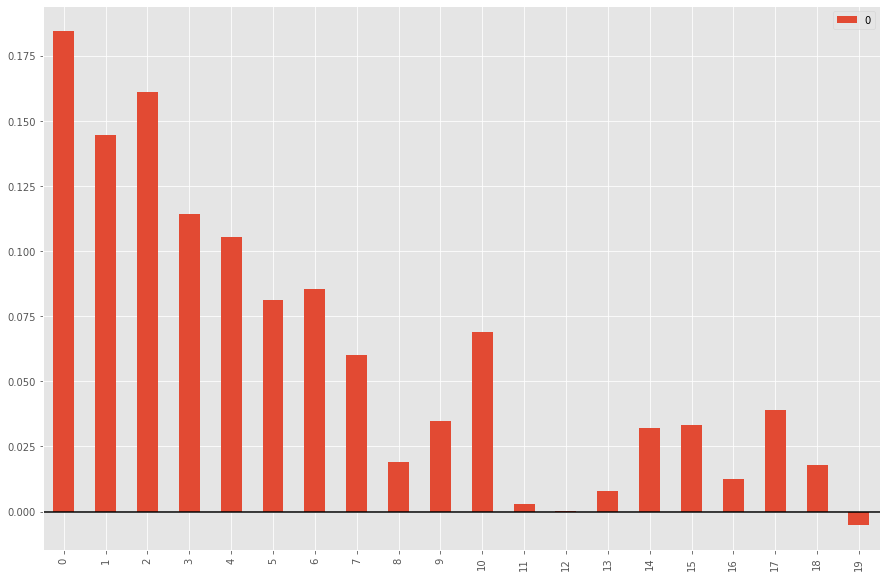

In [11]:
pd.DataFrame([(crypto_rets['ETH']**2).autocorr(ix) for ix in range(1,21)]).plot(kind='bar')
plt.axhline(0, color='black')

Text(0.5, 0, 'Geometric Returns')

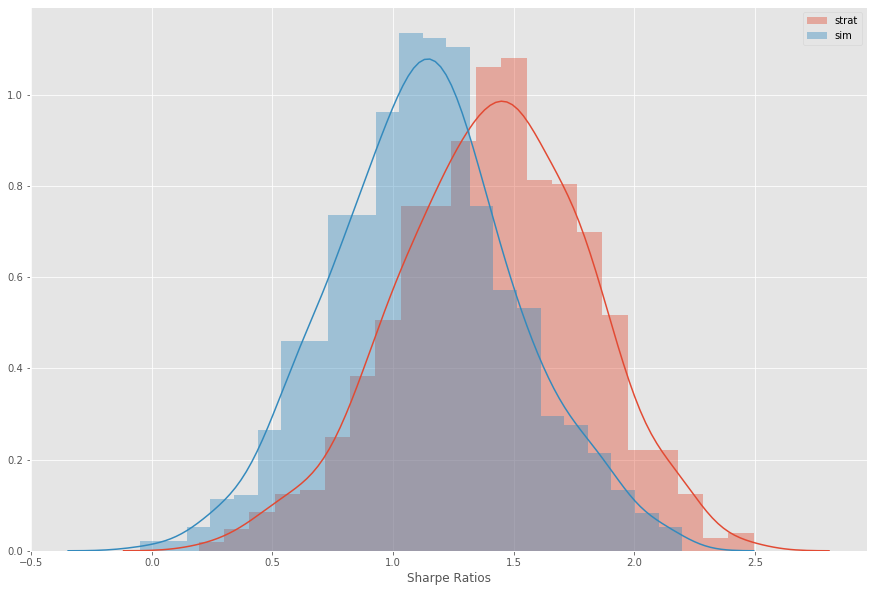

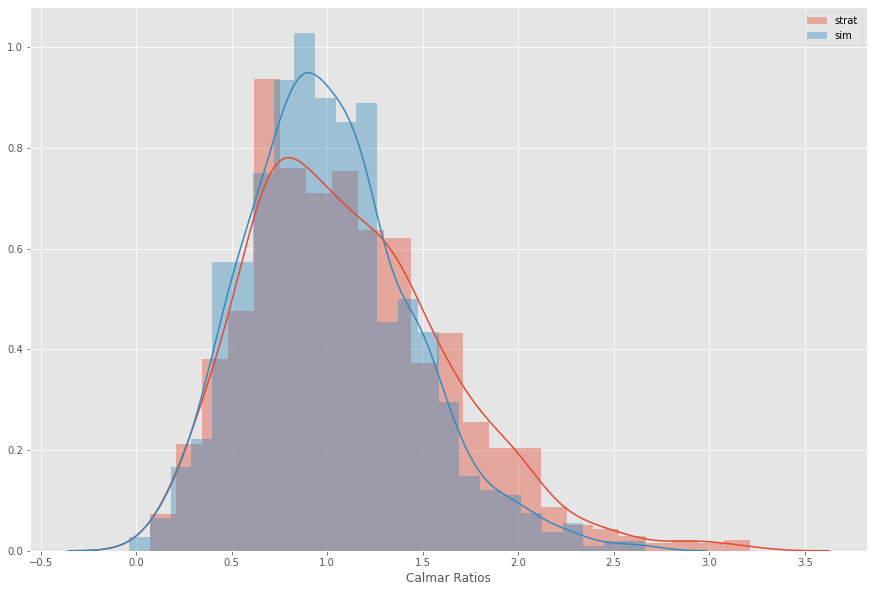

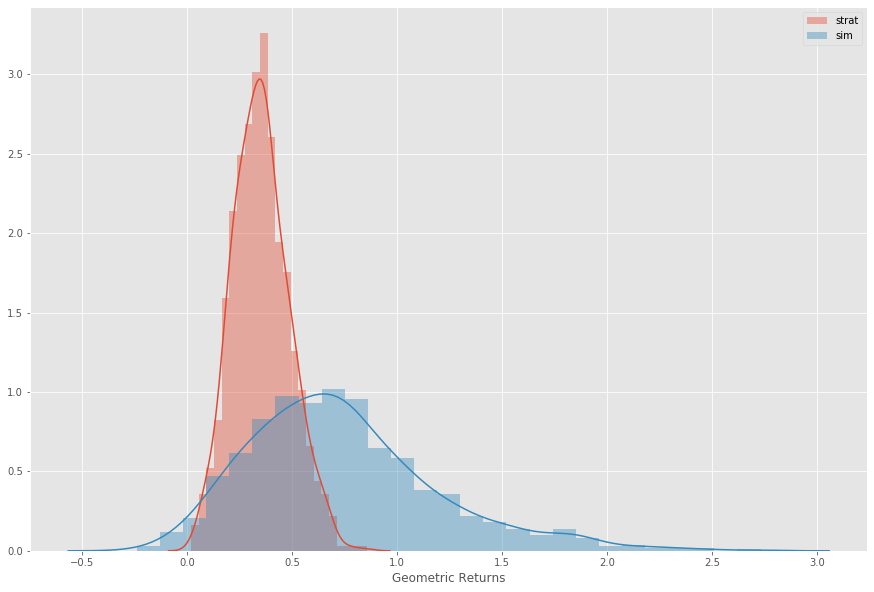

In [53]:
sharpe_df = pd.concat([strat_sims.dropna().apply(lambda x: x.mean()*np.sqrt(252)/x.std()),
                       btstrp_df.dropna().apply(lambda x: x.mean()*np.sqrt(252)/x.std())], axis=1)
calmar_df = pd.concat([strat_sims.dropna().apply(lambda x: (x.mean()*252)/(((1+x).cumprod().divide((1+x).cumprod().cummax())-1).abs().max())),
                       btstrp_df.dropna().apply(lambda x: (x.mean()*252)/((1+x).cumprod().divide((1+x).cumprod().cummax())-1).abs().max())], axis=1)
compound_df = pd.concat([strat_sims.dropna().apply(lambda x: (1+x).cumprod().iloc[-1]**(252/len(x))-1),
                       btstrp_df.dropna().apply(lambda x: (1+x).cumprod().iloc[-1]**(252/len(x))-1)], axis=1)


sharpe_df.columns = ['strat', 'sim']
calmar_df.columns = ['strat', 'sim']
compound_df.columns = ['strat', 'sim']

f1, ax1 = plt.subplots()
sns.distplot(sharpe_df['strat'], ax=ax1)
sns.distplot(sharpe_df['sim'], ax=ax1)
plt.legend(['strat', 'sim'])
plt.xlabel('Sharpe Ratios')

f2, ax2 = plt.subplots()
sns.distplot(calmar_df['strat'], ax=ax2)
sns.distplot(calmar_df['sim'], ax=ax2)
plt.legend(['strat', 'sim'])
plt.xlabel('Calmar Ratios')

f3, ax3 = plt.subplots()
sns.distplot(compound_df['strat'], ax=ax3)
sns.distplot(compound_df['sim'], ax=ax3)
plt.legend(['strat', 'sim'])
plt.xlabel('Geometric Returns')


In [81]:
(rets_df+1).cumprod().apply(get_bo_sig)

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
Date,,,,,,,,,,
2016-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-04-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2022-04-07,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0
2022-04-08,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0


(-0.922358700908047, 1.3511670134802582)

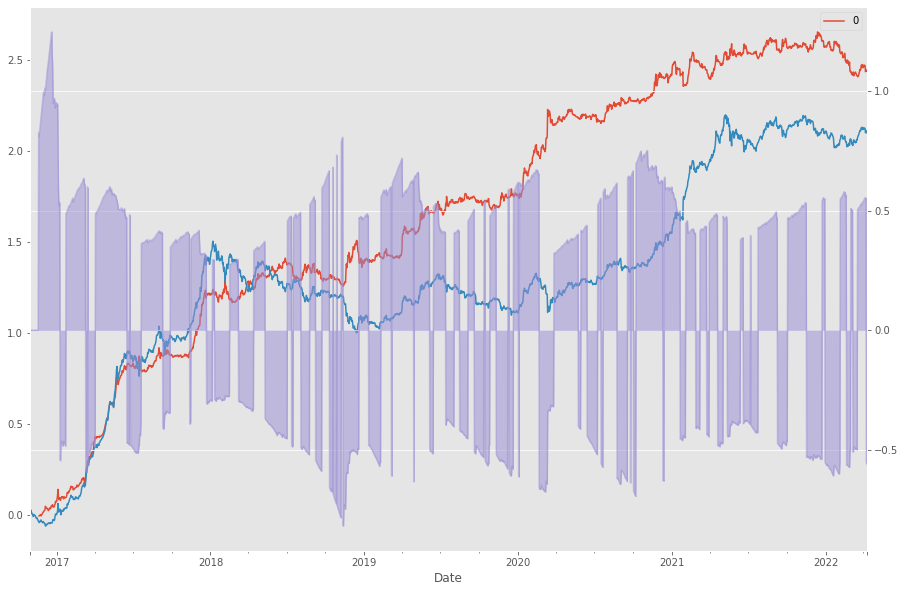

In [87]:
vol_tgt = 0.30

f, ax = plt.subplots()
position_size = ((rets_df+1).cumprod().apply(get_bo_sig)).multiply((vol_tgt/crypto_vols), axis=0)
position_size.shift(1).multiply(crypto_rets).mean(axis=1).dropna().cumsum().plot(ax=ax)
crypto_rets.mean(axis=1).to_frame().apply(lambda x: (0.013/x.std())*x).cumsum().plot(ax=ax)

position_size['BTC'].plot.area(ax=ax, stacked=False, secondary_y=True, alpha=0.5)
plt.ylim(None, None)

In [85]:
position_size.shift(1).multiply(crypto_prices.pct_change()).dropna().corr()

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
BTC,1.000000,0.424057,0.381190,0.294853,0.369686,0.471339,0.428509,0.281172,0.492433,0.345338
DASH,0.424057,1.000000,0.235458,0.234985,0.368246,0.416582,0.395316,0.251953,0.458783,0.507778
DCR,0.381190,0.235458,1.000000,0.196073,0.247199,0.322377,0.289637,0.259559,0.310496,0.253149
DOGE,0.294853,0.234985,0.196073,1.000000,0.255513,0.252543,0.256900,0.187807,0.254673,0.233841
ETC,0.369686,0.368246,0.247199,0.255513,1.000000,0.416509,0.383826,0.272439,0.347001,0.394176
ETH,0.471339,0.416582,0.322377,0.252543,0.416509,1.000000,0.377399,0.301135,0.428481,0.380495
LTC,0.428509,0.395316,0.289637,0.256900,0.383826,0.377399,1.000000,0.264307,0.344257,0.338200
XEM,0.281172,0.251953,0.259559,0.187807,0.272439,0.301135,0.264307,1.000000,0.292424,0.283941
XMR,0.492433,0.458783,0.310496,0.254673,0.347001,0.428481,0.344257,0.292424,1.000000,0.377329
ZEC,0.345338,0.507778,0.253149,0.233841,0.394176,0.380495,0.338200,0.283941,0.377329,1.000000


In [77]:
bo_signals.multiply(ivol_weights).shift(1).multiply(crypto_prices.pct_change()).dropna().apply(get_stats, args=(252,))

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
Arith. Mean,0.104604,0.084346,0.067861,0.124972,0.092581,0.121614,0.093747,0.113500,0.086489,0.062414
Compound Mean,0.107546,0.085204,0.067908,0.129285,0.093792,0.126305,0.094594,0.115776,0.087261,0.061944
Volatility,0.069904,0.072042,0.065708,0.082749,0.076676,0.072848,0.083091,0.090903,0.075385,0.068151
SR,1.496391,1.170796,1.032757,1.510243,1.207440,1.669416,1.128246,1.248581,1.147303,0.915812
t-Stat,4.181744,3.271851,2.886095,4.220454,3.374255,4.665270,3.152944,3.489226,3.206198,2.559286
Max DD,0.124655,0.091206,0.124796,0.076091,0.084199,0.110293,0.081789,0.098228,0.079069,0.119639
Calmar,0.839147,0.924786,0.543774,1.642398,1.099549,1.102638,1.146201,1.155469,1.093844,0.521681
Skewness,0.680575,3.766925,1.124635,5.516945,2.448654,0.961595,9.233667,14.336746,2.969214,2.360150
Kurtosis,8.903152,41.602567,7.090198,63.504704,24.422017,11.657502,208.507558,403.397500,40.535924,29.064602


In [86]:
position_size.shift(1).multiply(crypto_prices.pct_change()).dropna().apply(get_stats, args=(252,))

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
Arith. Mean,0.366093,0.313738,0.193327,0.358464,0.276520,0.415757,0.310477,0.411937,0.263627,0.221797
Compound Mean,0.371734,0.301771,0.157237,0.300550,0.256042,0.444411,0.287498,0.431637,0.241401,0.196312
Volatility,0.317898,0.318563,0.307806,0.392225,0.313268,0.310681,0.345218,0.335086,0.309615,0.293036
SR,1.151605,0.984855,0.628081,0.913923,0.882697,1.338209,0.899363,1.229348,0.851468,0.756893
t-Stat,3.218222,2.752228,1.755206,2.554006,2.466743,3.739696,2.513318,3.435477,2.379472,2.115177
Max DD,0.325624,0.451069,0.446845,0.635721,0.426135,0.323766,0.439959,0.295885,0.361786,0.327958
Calmar,1.124283,0.695544,0.432649,0.563869,0.648903,1.284126,0.705695,1.392220,0.728682,0.676297
Skewness,1.126920,1.370799,0.262140,-6.433200,0.967566,0.719711,3.221369,5.217749,1.077335,0.848370
Kurtosis,13.639576,13.333075,8.412211,227.552720,6.818852,6.769907,77.888239,98.292477,10.236940,6.349821


In [74]:
ivol_weights = crypto_vols.apply(lambda x: (1/x)/np.sum(1/x), axis=1)
bo_signals = (((rets_df+1).cumprod().apply(get_bo_sig)+1)/2)